In [1]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])


In [3]:
# Load the
video1 = cv2.VideoCapture('videos/1.mp4')
video2 = cv2.VideoCapture('videos/2.mp4')
video3 = cv2.VideoCapture('videos/3.mp4')
video4 = cv2.VideoCapture('videos/4.mp4')
video5 = cv2.VideoCapture('videos/5.mp4')

# Initialize mediapipe
mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=2, min_detection_confidence=0.7)
mpDraw = mp.solutions.drawing_utils


In [4]:
Y_labels = []
X_data = []
X_data_x = []
X_data_y = []

for n, video in enumerate([video1, video2, video3, video4, video5]):
    for i in range(int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
        # Read each frame from the webcam
        _, frame = video.read()

        x, y, c = frame.shape

        # Flip the frame vertically
        frame = cv2.flip(frame, 1)
        framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get hand landmark prediction
        result = hands.process(framergb)


        # post process the result
        if result.multi_hand_landmarks:
            landmarks = []
            landmarks_x = np.zeros(21)
            landmarks_y = np.zeros(21)
            for handslms in result.multi_hand_landmarks:
                for i,lm in enumerate(handslms.landmark):
                    # print(id, lm)
                    lmx = int(lm.x * x)
                    lmy = int(lm.y * y)

                    landmarks.append([lmx, lmy])
                    landmarks_x[i]= int(lmx)                  
                    landmarks_y[i]= int(lmy)

            X_data.append((landmarks))
            X_data_x.append(landmarks_x)
            X_data_y.append(landmarks_y)
            Y_labels.append(n)

In [5]:
# X_data = np.array(X_data)
Y_labels = np.array(Y_labels)
# print(X_data.shape)
X_data_x = np.array(X_data_x)
X_data_y = np.array(X_data_y)
# print(X_data_x.shape)
# print(X_data_x)
X_data = np.concatenate((X_data_x, X_data_y), axis=1)
print(X_data.shape)
print(Y_labels.shape)

(1691, 42)
(1691,)


In [6]:
def shuffle_in_unison(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [7]:
from sklearn.preprocessing import Normalizer


X_data1 = Normalizer().fit_transform(X_data)
X_data1, Y_labels = shuffle_in_unison(X_data1, Y_labels)
# Y_labels = tf.keras.utils.to_categorical(Y_labels, num_classes=5)
print(X_data1.shape)
print(Y_labels.shape)
print(Y_labels)

(1691, 42)
(1691,)
[1 4 2 ... 2 3 3]


In [129]:
model.predict(X_data1[0:1])

1/1 [==============================] - 0s 152ms/step


array([[0.1527982 , 0.1602507 , 0.18054935, 0.15323174, 0.15777446,
        0.1953955 ]], dtype=float32)

In [11]:
X_test = X_data1[0:int(X_data1.shape[0]*0.2)]
Y_test = Y_labels[0:int(Y_labels.shape[0]*0.2)]
X_train = X_data1[int(X_data1.shape[0]*0.2):]
Y_train = Y_labels[int(Y_labels.shape[0]*0.2):]


In [21]:
from sklearn.linear_model import SGDClassifier
X = X_train
y = Y_train
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
clf.fit(X, y)
SGDClassifier(max_iter=10)

c:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=10)

In [27]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1', 'elasticnet', 'none'], 'max_iter': [10, 100, 5]}
    ]

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)



c:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_mo

GridSearchCV(cv=5, estimator=SGDClassifier(max_iter=10),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'max_iter': [10, 100, 5],
                          'penalty': ['l2', 'l1', 'elasticnet', 'none']}],
             scoring='accuracy')

In [33]:
grid_search.best_params_

{'alpha': 0.0001, 'max_iter': 100, 'penalty': 'none'}

In [29]:
clf =  SGDClassifier(alpha=grid_search.best_params_['alpha'], max_iter=grid_search.best_params_['max_iter'], penalty=grid_search.best_params_['penalty'])
clf.fit(X, y)

SGDClassifier(max_iter=100, penalty='none')

In [30]:
Y_pred = clf.predict(X_test)
print(((Y_pred - Y_test)==0).sum())
print(Y_pred.shape)

320
(338,)


In [23]:
import seaborn as sns

<AxesSubplot:>

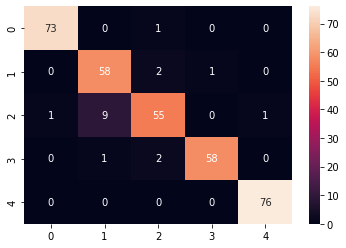

In [31]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(Y_test, Y_pred)
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True)

(array([74.,  0., 68.,  0.,  0., 60.,  0., 59.,  0., 77.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

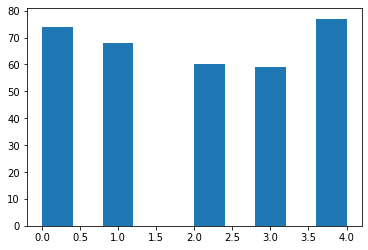

In [32]:
plt.hist(Y_pred)


(array([74.,  0., 61.,  0.,  0., 66.,  0., 61.,  0., 76.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

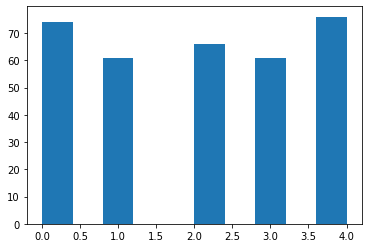

In [18]:
plt.hist(Y_test)

In [130]:
# Train the model
model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model.fit(X_data, Y_labels, epochs=100)


Epoch 1/100


ValueError: in user code:

    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\thoma\anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 6) are incompatible


In [89]:
model.predict(X_data[0:1])

1/1 [==============================] - 0s 57ms/step


array([[-3.5463734 ,  0.31527212,  0.22629353,  0.3493707 ,  0.19577055,
         0.35709056]], dtype=float32)